In [1]:
from biopandas.pdb import PandasPdb #libreria para trabajar con .pdb
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import scipy.fftpack as fourier
from statistics import mean
from scipy.stats import poisson
from scipy.linalg import expm
from scipy.special import erf
import math
import statistics
import os
from scipy.stats import linregress

# Crea redes de residuos de proteínas de los archivos pdb de un directorio (75 Mpro de SARS CoV 2) , calcula sus metricas promedio y genera graficas

# Crea una red G en base a un archivo pdb

In [2]:
def G_Pro1(D, pdb_file,file):
    # Lee el archivo PDB y convierte los datos en un DataFrame
    
    df = PandasPdb().read_pdb(pdb_file)

    # Filtra solo los carbonos alfa y toma solo el primero de cada residuo
    df_ca = df.df['ATOM'][df.df['ATOM']['atom_name'] == 'CA']
    df_ca = df_ca.groupby('residue_number').first().reset_index()
    
    # Filtra los residuos que se van a omitir(esto por que la mayoria de pdb s no toman en cuanra los atomos de los etremos de la proteina)
    df_ca = df_ca[~df_ca['residue_number'].isin([1, 2]) & ~df_ca['residue_number'].between(301, 306)]

    # Calcula la matriz de distancia entre los carbonos alfa
    distances = cdist(df_ca[['x_coord', 'y_coord', 'z_coord']], df_ca[['x_coord', 'y_coord', 'z_coord']])

    # Encuentra las parejas de carbonos alfa que están a menos de 7 Ångstroms
    ca_combinations = combinations(range(len(distances)), 2)
    ca_pairs = [(df_ca.iloc[i]['residue_number']-3, df_ca.iloc[j]['residue_number']-3)
                for i, j in ca_combinations if distances[i][j] < D]

    # Obtener el número de nodos
    nodos = list(set(sum(ca_pairs, ())))
    num_nodos = len(nodos)

    # Crear una matriz de ceros de tamaño num_nodos x num_nodos
    matriz = np.zeros((num_nodos, num_nodos))

    # Llenar la matriz con las conexiones
    for conexion in ca_pairs:
        i = nodos.index(conexion[0])
        j = nodos.index(conexion[1])
        matriz[i][j] = 1
        matriz[j][i] = 1

    # Crea un objeto Graph de networkx y agrega los nodos y las aristas a partir de la matriz de adyacencia
    GMpro1 = nx.Graph(matriz)

    # Imprimir el resultado del numero de nodos para cada archivo
    print("El número de nodos de la red", file ,"es:", num_nodos)

    return GMpro1


# Calcula las métricas de la red 


In [3]:
#redondea las componentes de la matriz para evitar errores
def redondear_matriz(matriz, cifras_decimales):
    matriz_numerica = np.array(matriz, dtype=float)  # Convertir la matriz a tipo float
    matriz_redondeada = np.round(matriz_numerica, cifras_decimales)
    return matriz_redondeada
#funcion doble factorial
def double_factorial(k):
    if k <= 0:
        return 1
    else:
        return k * double_factorial(k-2) if k <= 19 else math.prod(range(k, 0, -2))
#funcion matriz de centralidad subgrafica de largo alcance, kmax es el numero de interaciones de la sumatoria  
#se utiliza el metodo de sumatoria
def MZ(G, k_max):
    A = nx.adjacency_matrix(G).todense()
    suma = np.identity(A.shape[0], dtype=float)
    potencia_A = np.identity(A.shape[0], dtype=float)
    suma_values = []  # Lista para almacenar los valores de suma
    for k in range(1, k_max+1):
        df = double_factorial(int(k))
        potencia_A = np.matmul(potencia_A, A)
        #print(potencia_A)
        suma += redondear_matriz(potencia_A/df, 10)
        
    return suma
#funcion matriz de centralidad subgrafica,kmax es el numero de interaciones de la sumatoria
#se utiliza el metodo de sumatoria
def MG(G, k_max):
    A = nx.adjacency_matrix(G).todense()
    suma = np.identity(A.shape[0], dtype=float)
    potencia_A = np.identity(A.shape[0], dtype=float)
    suma_values = []  # Lista para almacenar los valores de suma
    for k in range(1, k_max+1):
        df = math.factorial(int(k))       
        potencia_A = np.matmul(potencia_A, A)
        #print(potencia_A)
        suma += redondear_matriz(potencia_A/df, 10)
     
    
    return suma
#Calcula diversas centralidades para cada red
def centralidad(G):
    
    # Calcula la densidad de la red
    density = nx.density(G)
    

    #Calcula el grado de heterogeneidad de la red G.
   
    n = len(G.nodes())
    het_sum = 0.0

    for node in G.nodes:
        for neighbor in G.neighbors(node):
            if node < neighbor:  # para evitar parejas duplicadas
                degree_node = G.degree(node)
                degree_neighbor = G.degree(neighbor)
                het_sum += (degree_node**(-0.5) - degree_neighbor**(-0.5))**2
                #print(f"({node}, {neighbor}): ({degree_node**(-0.5)}, {degree_neighbor**(-0.5)},{(degree_node**(-0.5) - degree_neighbor**(-0.5))**2})")

    het_sum = het_sum/(nx.number_of_nodes(G)-2*(nx.number_of_nodes(G)-1)**0.5) #normalizando
    
    # Calcula la centralidad de eigenvalor de cada nodo de la red:
    
    eigen_centrality = nx.eigenvector_centrality(G, max_iter=1500)
    
    # Promedio de la centralidad de eigenvalor 
    
    average_eigen_centrality = sum(eigen_centrality.values()) / n

    
    # Calcula la longitud media del camino
    average_path_length = nx.average_shortest_path_length(G)
    
    # Calcular el promedio de coeficiente de agrupamiento de Watts-Strogatz (clustering coefficient)
    avg_watts_strogatz_cc = nx.average_clustering(G, count_zeros=True)
    
    # Calcular el grado de asociatividad
    
    r=nx.degree_assortativity_coefficient(G)
    
    # Calcula betweenness centrality para cada nodo
    bc = nx.betweenness_centrality(G,normalized=False)

    # Suma los valores de betweenness centrality de todos los nodos
    total_bc = sum(bc.values())

    # Calcula el average betweenness centrality
    avg_bc = total_bc / len(bc)
    
    # Calcula la matriz de centralidad subgrafica de la red, esto es igual a exp(A)  
    
    exp_A = MG(G,25)
    
    # Accede a los elementos de la diagonal de exp_A y calcula su media
    avg_diag = np.mean(np.diag(exp_A))
    
    # Promedia todas las entradas de exp_A excepto la diagonal, esto es la comunicabilidad 
    avg_c = np.mean(exp_A[np.where(~np.eye(exp_A.shape[0], dtype=bool))])  
    
    # Calcula la matriz de centralidad subgrafica de de largo alcance   
    z = MZ(G,150)
    
    # Accede a los elementos de la diagonal de z y calcula su media
    avg_diag_z = np.mean(np.diag(z))
    
    # Promedia todas las entradas de z excepto la diagonal, esto es la comunicabilidad de LR
    avg_z = np.mean(z[np.where(~np.eye(z.shape[0], dtype=bool))])
    
    # Calcula el angulo de comunicabilidad de la matriz A 
    
    # Inicializamos la variable de suma
    suma = 0

    # Recorremos todas las entradas de la matriz A que no están en la diagonal
    for i in range(n):
        for j in range(n):
            if i != j:
                # Calculamos la operación cos a la -1 (Aij/sqrt(Aii*Ajj)) en cada entrada
                suma += math.degrees(np.arccos(exp_A[i,j]/np.sqrt(exp_A[i,i]*exp_A[j,j])))


    # Calculamos el promedio de todas las operaciones
    Angulo = suma/(n*(n-1))  
    
    
    return  density,het_sum,average_path_length,avg_watts_strogatz_cc,r,avg_bc,average_eigen_centrality,avg_diag,avg_c,Angulo, avg_diag_z,avg_z

# Grafica Nodo vs Centralidad Subgrafica (diagonal de MG y MZ) por medio de matrices G y Z de centralidad cada red.  

In [4]:
#centralidad Subgrafica promedio de las redes (elementos en la diagonal de la matriz G)
def centralidad_sub(MGs):
    n = len(MGs[0])
    # Creamos una lista vacía para almacenar los elementos diagonales 
    elementos_diagonal = [0] * n
    desviaciones_estandar = [0] * n

    # Iteramos sobre las diagonales de las matrices
    for i in range(n):
        # Obtenemos los elementos diagonales correspondientes
        diagonal_elements = [G[i, i] for G in MGs]
        # Calculamos el promedio de los elementos diagonales correspondientes
        promedio_diagonal = np.mean(diagonal_elements)
        desviacion_estandar = np.std(diagonal_elements)
        # Agregamos el promedio y la desviación estándar a las listas correspondientes
        elementos_diagonal[i] = promedio_diagonal
        desviaciones_estandar[i] = desviacion_estandar
       

    # Graficamos los promedios en función del número de elemento en la diagonal
    num_elementos = n
    plt.figure(figsize=(20,10)) 
    plt.plot(range(1, num_elementos + 1), elementos_diagonal, '-o')
    #plt.errorbar(range(1, num_elementos + 1), elementos_diagonal, yerr=desviaciones_estandar, fmt='o',color='red',markerfacecolor='red', ecolor='blue',capsize=5)
    plt.xlim(0,300) 
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica')
    plt.title("Centralidad subgrafica promedio")
    plt.grid(True)
    if save_graph.lower() == 'y':
        plt.savefig(f"Centralidad sub prom 75 redes R={D}A.png", dpi=200) 
    # Mostrar la gráfica
    plt.show()
#centralidad Subgrafica de las m primeras redes (elementos en la diagonal de la matriz G)
def centralidad_n(MGs,m):
    n = len(MGs[0])
    plt.figure(figsize=(20,10))
    # Iterar sobre las primeras n redes
    for j in range(m):
        diagonal_elements = [MGs[j][i, i] for i in range(n)]
        
        # Graficar los elementos de la diagonal de la red j
        plt.plot(range(n), diagonal_elements, label=f"Red {j+1}")
        
    # Configurar la leyenda y el título de la gráfica
    plt.xlim(0,300) 
    plt.legend()
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica')
    plt.title("Centralidad subgrafica de las primeras m redes")
    plt.grid(True)
    if save_graph.lower() == 'y':
        plt.savefig(f"Centralidad sub de m redes R={D}A.png", dpi=200) 
    # Mostrar la gráfica
    plt.show()
#centralidad Subgrafica de Largo Alcance promedio de las redes (elementos fuera de la diagonal de la matriz Z)
def LR_centralidad_sub(MZs):
    n = len(MZs[0])
    # Creamos una lista vacía para almacenar los elementos diagonales
    elementos_diagonal = [0] * n
    desviaciones_estandar = [0] * n

    # Iteramos sobre las diagonales de las matrices
    for i in range(n):
        # Obtenemos los elementos diagonales correspondientes
        diagonal_elements = [Z[i, i] for Z in MZs]
        # Calculamos el promedio de los elementos diagonales correspondientes
        promedio_diagonal = np.mean(diagonal_elements)
        desviacion_estandar = np.std(diagonal_elements)
        # Agregamos el promedio y la desviación estándar a las listas correspondientes
        elementos_diagonal[i] = promedio_diagonal
        desviaciones_estandar[i] = desviacion_estandar
       

    # Graficamos los promedios en función del número de elemento en la diagonal
    num_elementos = n
    plt.figure(figsize=(20,10)) 
    plt.plot(range(1, num_elementos + 1), elementos_diagonal, '-o')
    #plt.errorbar(range(1, num_elementos + 1), elementos_diagonal, yerr=desviaciones_estandar, fmt='o',color='red',markerfacecolor='red', ecolor='blue',capsize=5)
    plt.xlim(0,300) 
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica de LA')
    plt.title("Centralidad subgrafica promedio de LA")
    plt.grid(True)
    if save_graph.lower() == 'y':
        plt.savefig(f"Centralidad sub prom de LA de 75 redes R={D}A.png", dpi=200) 
    plt.show()
# ditribucion centralidad Subgrafica de Largo Alcance promedio de las redes
def LR_centralidad_sub_dist(MZs):
    n = len(MZs[0])
    elementos_diagonal = []

    for i in range(n):
        diagonal_elements = [Z[i, i] for Z in MZs]
        promedio_diagonal = np.mean(diagonal_elements)
        elementos_diagonal.append(promedio_diagonal)
       
    plt.figure(figsize=(20, 10))
    plt.hist(elementos_diagonal, bins=20, color='blue', edgecolor='black', log=True)  # Escala logarítmica
    plt.xlabel('Centralidad subgrafica de LA')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Frecuencia de Centralidades Subgráficas de LA (Escala Logarítmica)')
    plt.grid(True)
    if save_graph.lower() == 'y':
        plt.savefig(f"Distribución Subgráficas de LA R={D}A.png", dpi=200)            
    plt.show()    

# centralidad Subgrafica de Largo Alcance de las m primeras redes (elementos fuera de la diagonal de la matriz Z)     
def centralidad_LR_n(MZs,m):
    n = len(MZs[0])
    plt.figure(figsize=(20,10))
    # Iterar sobre las primeras n redes
    for j in range(m):
        diagonal_elements = [MZs[j][i, i] for i in range(n)]
        
        # Graficar los elementos de la diagonal de la red j
        plt.plot(range(n), diagonal_elements, label=f"Red {j+1}")
        
    # Configurar la leyenda y el título de la gráfica
    plt.xlim(0,300) 
    plt.legend()
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica de LA')
    plt.title("Centralidad subgrafica de LA de las primeras m redes")
    plt.grid(True)  
    if save_graph.lower() == 'y':
        plt.savefig(f"Centralidad sub de LA de m redes R={D}A.png", dpi=200)
    # Mostrar la gráfica
    plt.show() 
    # centralidad Subgrafica de Largo Alcance de las m primeras redes (elementos fuera de la diagonal de la matriz Z)     
def centralidad_Clossnes_n(G,m):
    n = len(G[0])
    plt.figure(figsize=(20,10))
    # Iterar sobre las primeras n redes
    for j in range(m):
        diagonal_elements = [MZs[j][i, i] for i in range(n)]
        
        # Graficar los elementos de la diagonal de la red j
        plt.plot(range(n), diagonal_elements, label=f"Red {j+1}")
        
    # Configurar la leyenda y el título de la gráfica
    plt.xlim(0,300) 
    plt.legend()
    plt.xlabel('Residuo')
    plt.ylabel('Centralidad subgrafica de LA')
    plt.title("Centralidad subgrafica de LA de las primeras m redes")
    plt.grid(True)  
    if save_graph.lower() == 'y':
        plt.savefig(f"Centralidad sub de LA de m redes R={D}A.png", dpi=200)
    # Mostrar la gráfica
    plt.show() 

# Crea las matrices G y Z para un radio de corte D y en base a los archivos pdb en un directorio dado.

In [73]:
D = 9.0 # radio de corte para residuos

# Directorio que contiene los archivos pdb
dir_path = "pdb_Mpro"

# Obtener una lista de todos los archivos pdb en la carpeta
pdb_files = [f for f in os.listdir(dir_path) if f.endswith('.pdb')]

# Crear la lista de redes
redes = []
for pdb_file in pdb_files:
    red = G_Pro1(D, os.path.join(dir_path, pdb_file),pdb_file)
    redes.append(red)
    
# Crear la lista de matrices Z
MZs = []
for red in redes:
    Z = MZ(red,150)
    MZs.append(Z)    

    
# Crear la lista de matrices G, imprime el numero de nodos de la red de cada archivo pdb
MGs = []
for red in redes:
    G = MG(red,25)
    MGs.append(G)      
    
# No guardar la gráficas por defecto
save_graph = 'n'
        
         

El número de nodos de la red 5r84.pdb es: 298
El número de nodos de la red 5re9.pdb es: 298
El número de nodos de la red 5reb.pdb es: 298
El número de nodos de la red 5rei.pdb es: 298
El número de nodos de la red 5rek.pdb es: 298
El número de nodos de la red 5res.pdb es: 298
El número de nodos de la red 5reu.pdb es: 298
El número de nodos de la red 5rfm.pdb es: 298
El número de nodos de la red 5rfp.pdb es: 298
El número de nodos de la red 5rfr.pdb es: 298
El número de nodos de la red 6w63.pdb es: 298
El número de nodos de la red 6wnp.pdb es: 298
El número de nodos de la red 6xqs.pdb es: 298
El número de nodos de la red 6xqu.pdb es: 298
El número de nodos de la red 6xr3.pdb es: 298
El número de nodos de la red 7a1u.pdb es: 298
El número de nodos de la red 7aeh.pdb es: 298
El número de nodos de la red 7aqj.pdb es: 298
El número de nodos de la red 7ar6.pdb es: 298
El número de nodos de la red 7au4.pdb es: 298
El número de nodos de la red 7aws.pdb es: 298
El número de nodos de la red 7ax6.

# Preguntar si desea guardar las gráficas

In [74]:
# Preguntar si deseas guardar la gráfica
save_graph = input("¿Deseas guardar la gráfica? (y/n): ")

¿Deseas guardar la gráfica? (y/n): y


# Calcula el promedio de las principales centralidades de las redes 

In [7]:
# Promedio de centralidad de las redes. 
promedio_final = tuple(statistics.mean(sublista) for sublista in zip(*[centralidad(red)[0:] for red in redes]))

# Crea una lista de los nombres de centralidades que se van a promediar en orden
nombres_centralidades = ["Densidad de la red\t", "Heterogeneidad de la red", "Longitud de camino medio",
                        "Coeficiente de agrupamiento", "Coeficiente de asociatividad",
                        "centralidad de intermediación","centralidad de eigenvalor","Centralidad subgrafica\t",
                        "Comunicabilidad\t\t","Angulo de comunicabilidad","Centralidad subgrafica LR",
                        "Comunicabilidad de LR\t"]

# Imprime la tabla con los nombres de centralidades y los promedios calculados
print("Tabla de Centralidades y Promedios")
print("Centralidad\t\t\t\tPromedio")
for nombre, promedio in zip(nombres_centralidades, promedio_final):
    print(f"{nombre}\t\t{promedio}")

Tabla de Centralidades y Promedios
Centralidad				Promedio
Densidad de la red			0.03243501382203843
Heterogeneidad de la red		0.01572252549602341
Longitud de camino medio		5.395090050392064
Coeficiente de agrupamiento		0.5304679262484233
Coeficiente de asociatividad		0.4405037857512929
centralidad de intermediación		652.6708724832215
centralidad de eigenvalor		0.03471269309812828
Centralidad subgrafica			1113.59290072917
Comunicabilidad				249.9107362955129
Angulo de comunicabilidad		75.59558193781363
Centralidad subgrafica LR		4.5649404761350834e+29
Comunicabilidad de LR			1.6006700972996594e+29


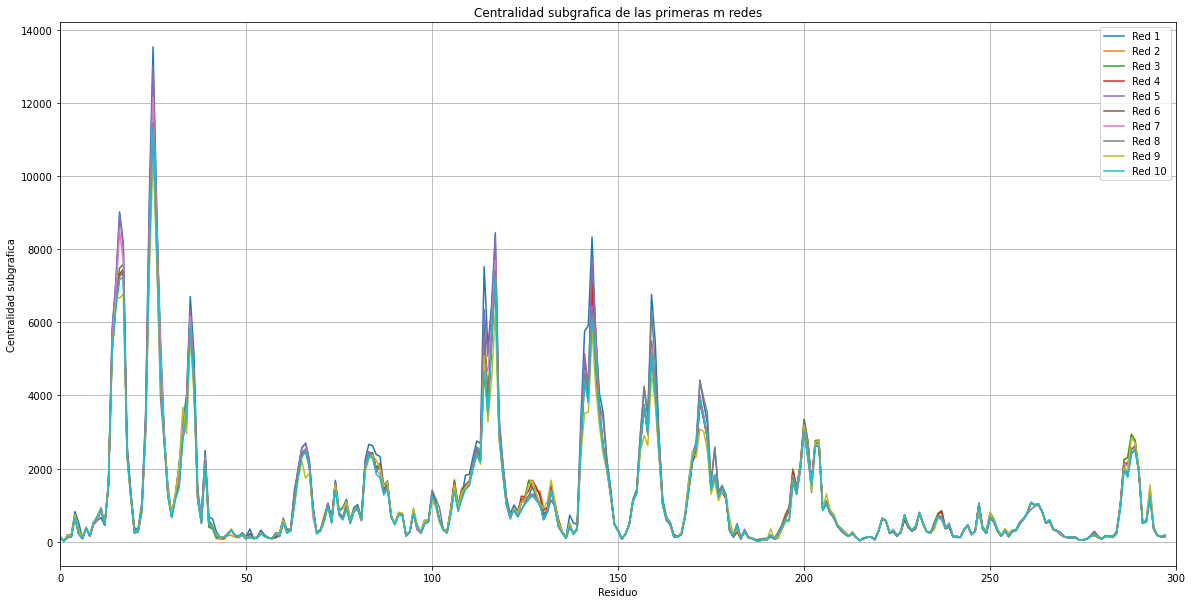

In [8]:
# Obtenemos la centralidad de subgrafica
centralidad_n(MGs,10)

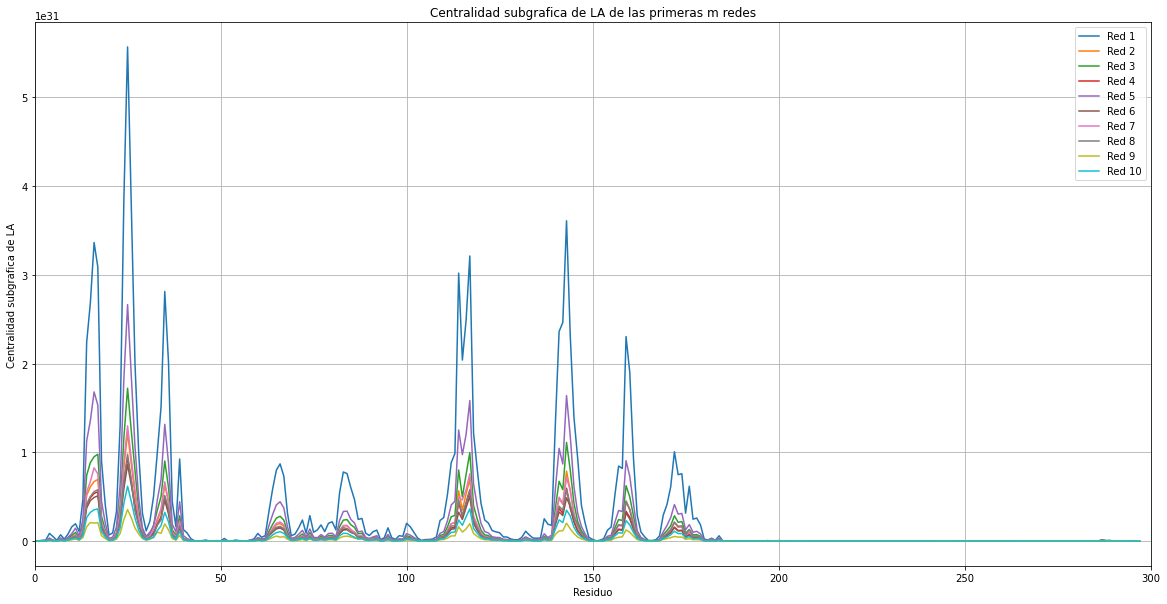

In [9]:
centralidad_LR_n(MZs,10)

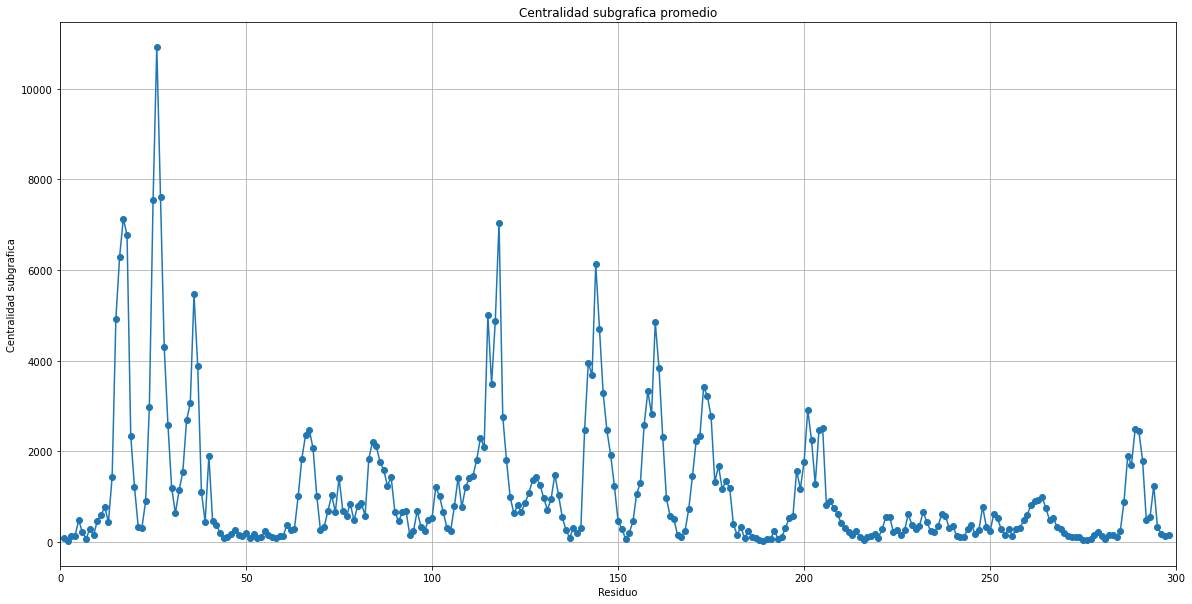

In [10]:
# Obtenemos la centralidad de subgrafica promedio
centralidad_sub(MGs)

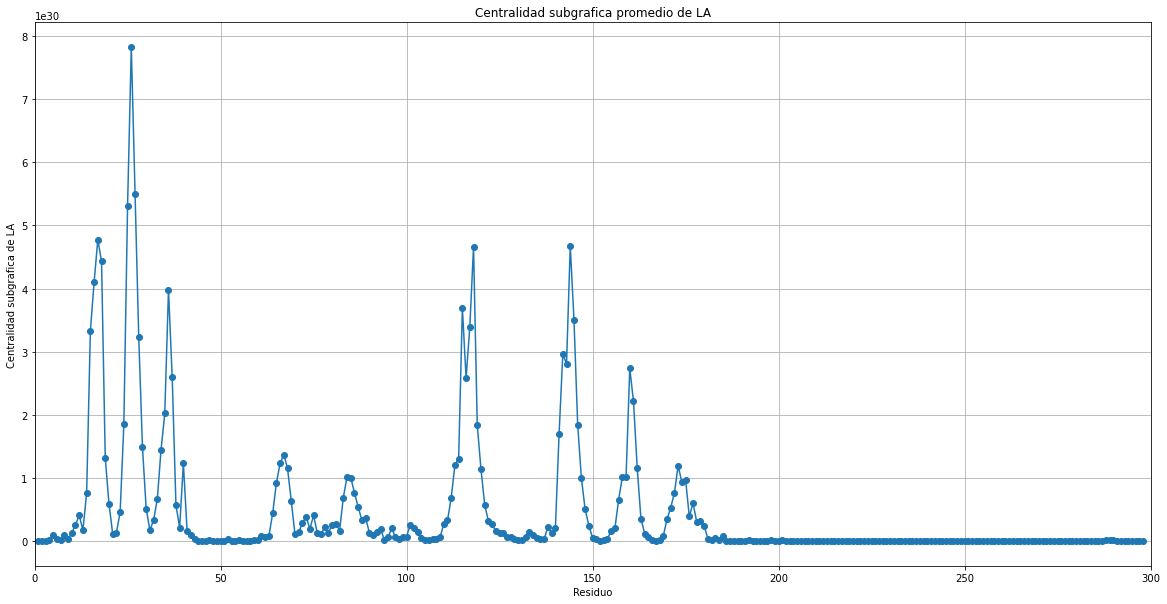

In [11]:
# Obtenemos la centralidad de subgrafica de largo alcance LA promedio
LR_centralidad_sub(MZs)

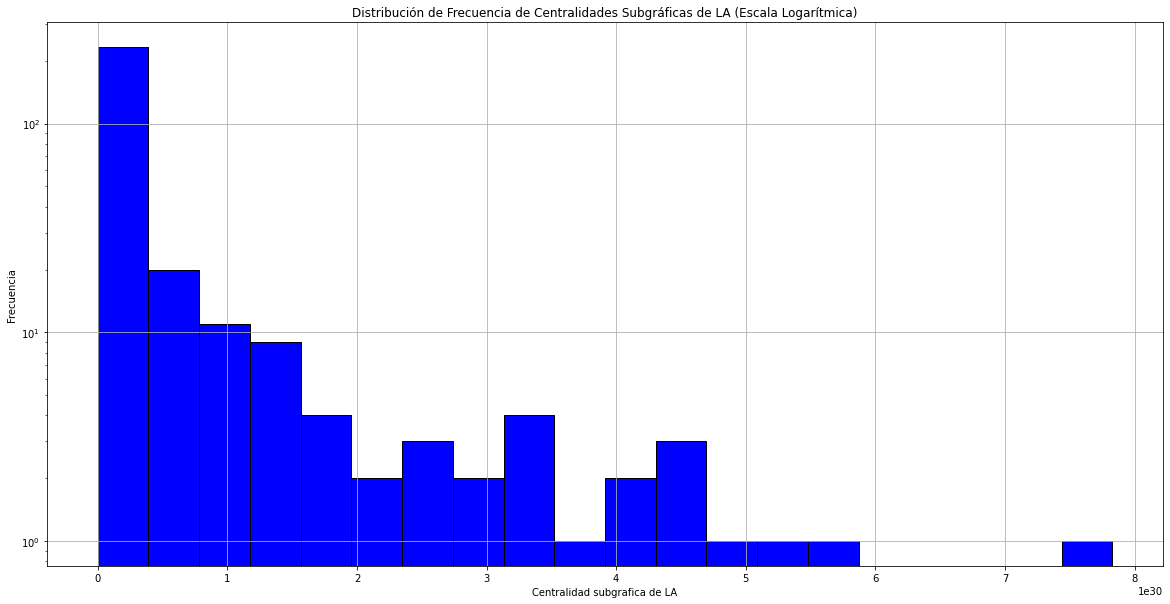

In [12]:
LR_centralidad_sub_dist(MZs)

# Ranking de nodos con maxima centralidad Subgrafica de las n primeras matrices G. 

In [13]:
n = 6
def max_diagonal_elements(MGs):
    max_values = []
    #encontra los nodos con mayor centralidad de las n=3 primeras matrices G
    for j in range(n):
        diagonal_elements = [MGs[j][i, i] for i in range(len(MGs[j]))]
        # Ordenamos los valores diagonales en orden descendente
        diagonal_sorted = np.sort(diagonal_elements)[::-1]
        # Tomamos los índices de los 10 mayores valores diagonales
        top_indices = np.argsort(diagonal_elements)[::-1][:10]+3
        max_values.append(top_indices)
    return max_values

max_values = max_diagonal_elements(MGs)

# Imprime la tabla del ranking de residuos con mayor centralidad de las n primeras redes

for i in range(n):
    print("Ranking de Centralidad Subgrafica de LR de la red:",i+1)
    print("Posición\tResiduo")
    for j, residuo in enumerate(max_values[i], start=1):
        print(f"{j}\t\t{residuo}")

Ranking de Centralidad Subgrafica de LR de la red: 1
Posición	Residuo
1		28
2		27
3		19
4		29
5		120
6		146
7		20
8		117
9		18
10		162
Ranking de Centralidad Subgrafica de LR de la red: 2
Posición	Residuo
1		28
2		29
3		27
4		120
5		20
6		146
7		19
8		18
9		38
10		117
Ranking de Centralidad Subgrafica de LR de la red: 3
Posición	Residuo
1		28
2		29
3		27
4		120
5		146
6		20
7		19
8		18
9		38
10		117
Ranking de Centralidad Subgrafica de LR de la red: 4
Posición	Residuo
1		28
2		27
3		29
4		120
5		20
6		19
7		146
8		18
9		38
10		117
Ranking de Centralidad Subgrafica de LR de la red: 5
Posición	Residuo
1		28
2		27
3		19
4		29
5		120
6		20
7		146
8		18
9		38
10		117
Ranking de Centralidad Subgrafica de LR de la red: 6
Posición	Residuo
1		28
2		29
3		27
4		20
5		120
6		19
7		18
8		146
9		38
10		119


# Ranking de nodos con maxima centralidad Subgrafica de Largo Alcance (LR) promedio las matrices Z. 

In [14]:
def max_diagonal_prom(MZs):
    max_values = []
    n = len(MZs[0])
    # Creamos una lista vacía para almacenar los elementos diagonales
    elementos_diagonal = [0] * n
        
    for i in range(n):
        # Obtenemos los elementos diagonales correspondientes
        diagonal_elements = [Z[i, i] for Z in MZs]
        # Calculamos el promedio de los elementos diagonales correspondientes
        promedio_diagonal = np.mean(diagonal_elements)
        # Agregamos el promedio a las lista correspondiente
        elementos_diagonal[i] = promedio_diagonal
    #print(elementos_diagonal)    
    # Ordenamos los valores diagonales en orden descendente
    diagonal_sorted = np.sort(elementos_diagonal)[::-1]
    # Tomamos los índices de los 22 mayores valores diagonales, el 3 es para coincidir con el numero de reciduo de la proteina
    top_indices = np.argsort(elementos_diagonal)[::-1][:22]+3
    max_values.append(top_indices)
    return max_values

max_values = max_diagonal_prom(MZs)

# Imprime la tabla del ranking de residuos con mayor centralidad
print("Ranking de Centralidad Subgrafica de LR promedio")
print("Posición\tResiduo")
for i, residuo in enumerate(max_values[0], start=1):
    print(f"{i}\t\t{residuo}")

Ranking de Centralidad Subgrafica de LR promedio
Posición	Residuo
1		28
2		29
3		27
4		19
5		146
6		120
7		20
8		18
9		38
10		117
11		147
12		119
13		17
14		30
15		144
16		145
17		162
18		39
19		118
20		163
21		37
22		26


# Grafica de centralida subgrafica promedio

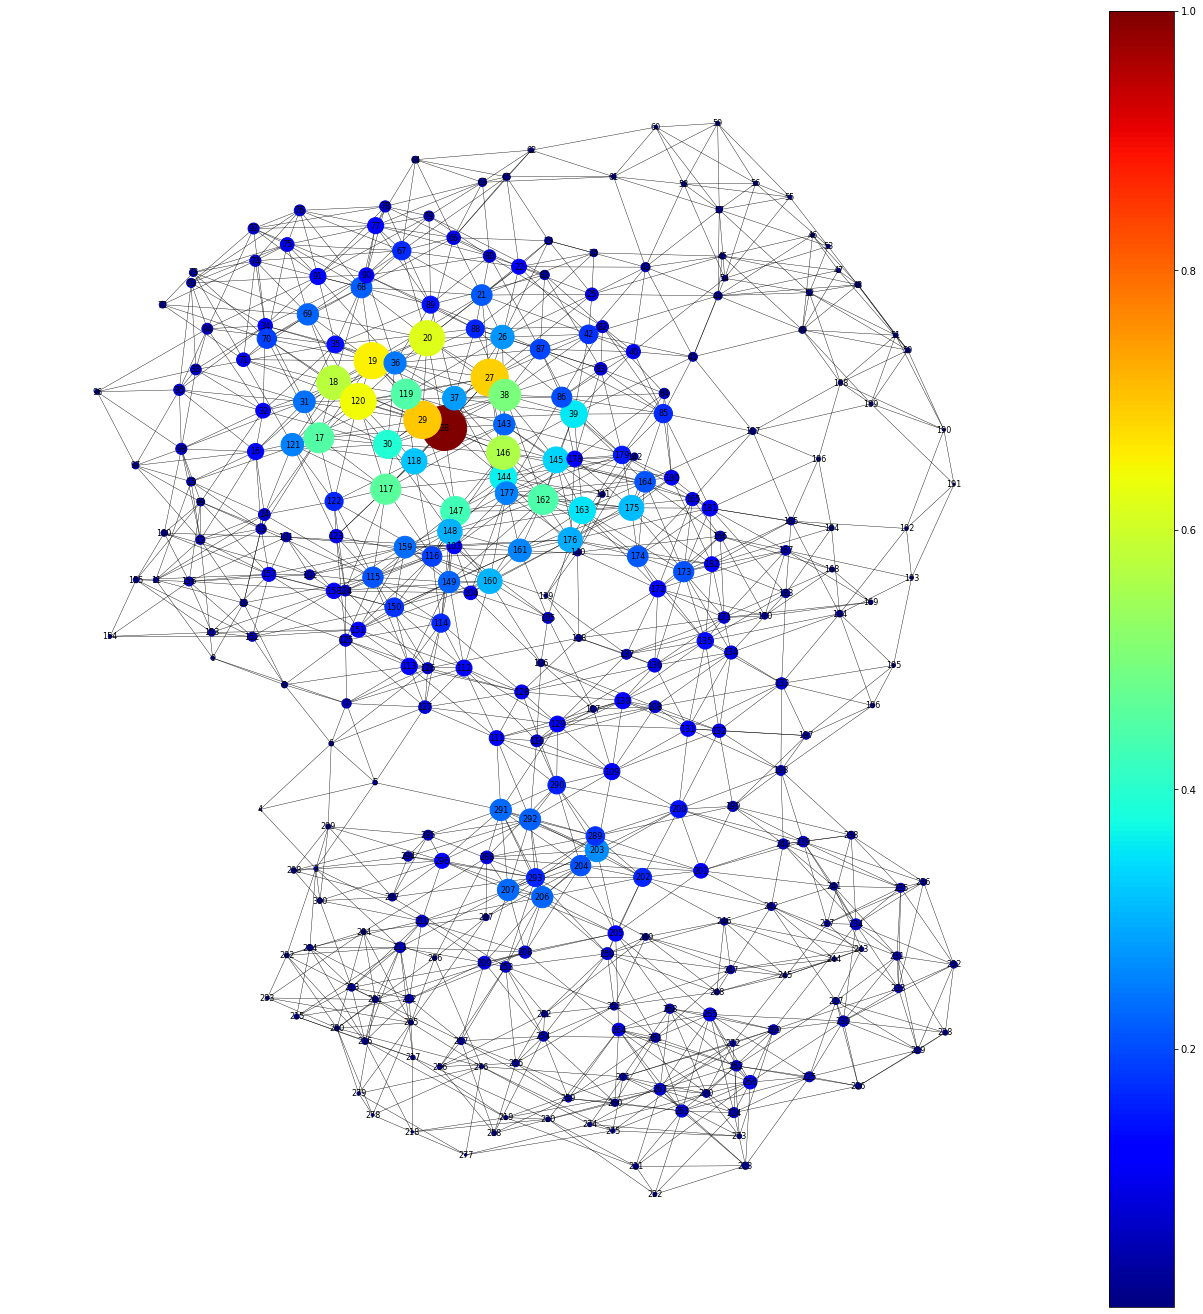

In [15]:
# Calcular los valores promedio de la diagonal de cada matriz G
diagonal_means = np.mean([np.diag(G) for G in MGs], axis=0)

# Normalizar los valores promedio de la diagonal
diagonal_means_norm = diagonal_means / np.max(diagonal_means)

# Crear un mapeo para la nueva numeración de los nodos
mapping = {n: n + 3 for n in red.nodes()}

# Obtener la red con la numeración de los nodos modificada
red_numerada = nx.relabel_nodes(red, mapping)

# Graficar la red con la nueva numeración de los nodos
plt.figure(1, figsize=(18, 18))
nx.draw_kamada_kawai(red_numerada, node_size=diagonal_means_norm*2000, cmap=plt.cm.jet, node_color=diagonal_means_norm, width=0.4, font_size=8, with_labels=True, font_color="Black")
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(diagonal_means_norm), vmax=max(diagonal_means_norm)))
sm.set_array([])
plt.colorbar(sm)

if save_graph.lower() == 'y':
    plt.savefig(f"Centralidad subgrafica prom 75 redes R={D}A.png", dpi=200) 
plt.show()


# Grafica de centralida subgrafica de LR promedio

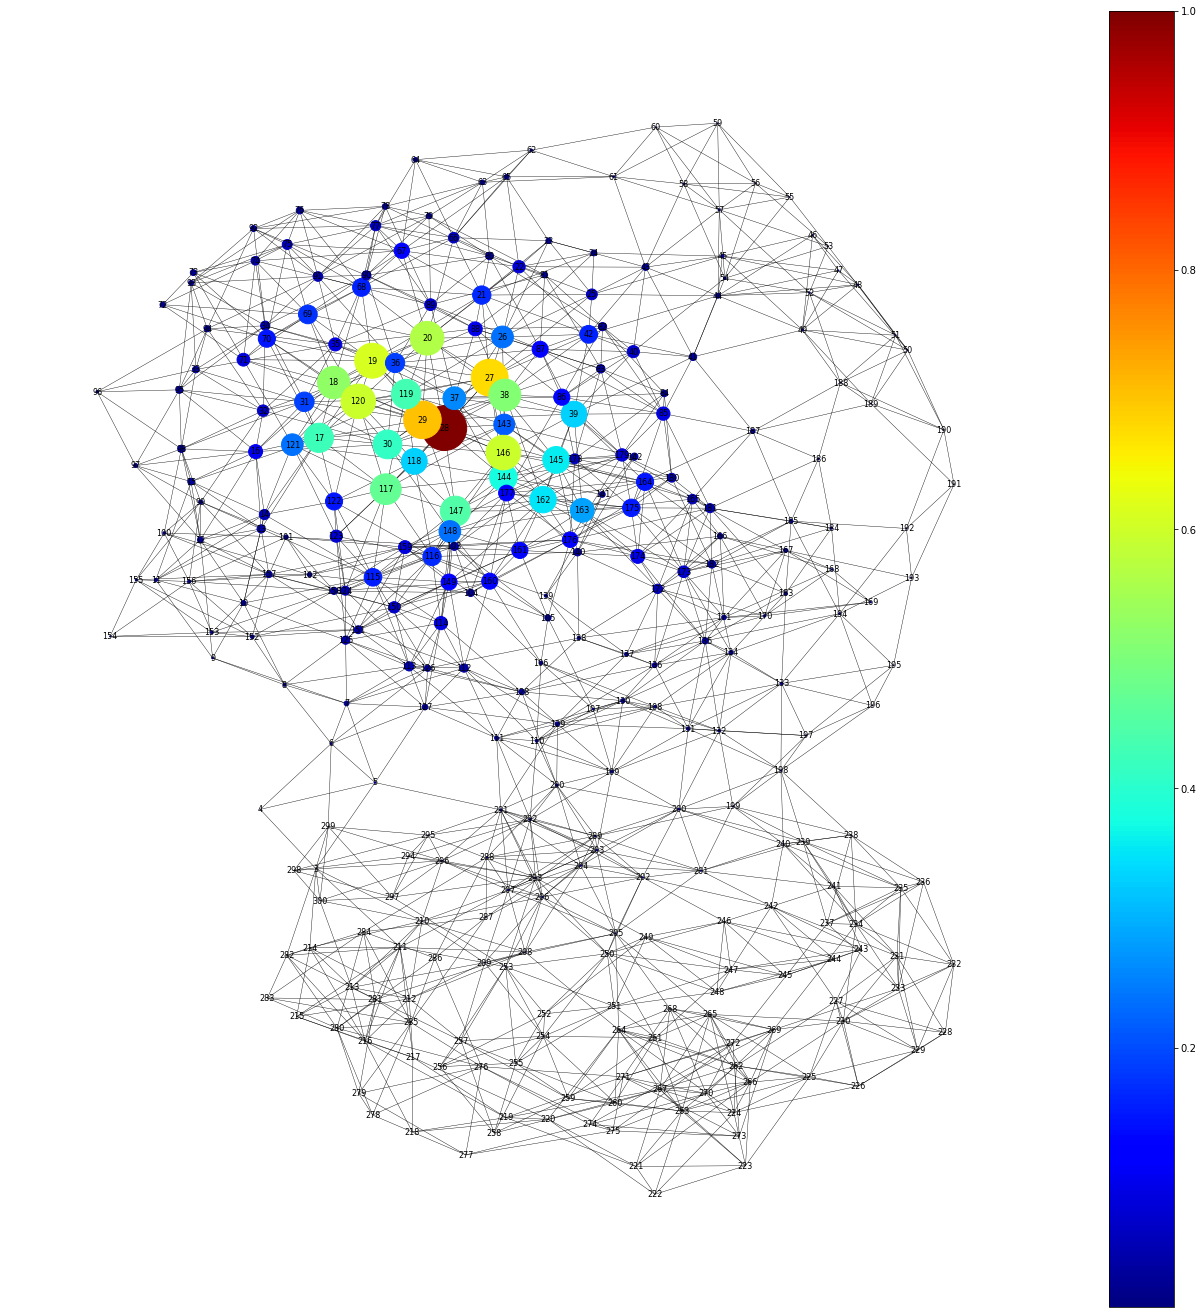

In [16]:
# Calcular los valores promedio de la diagonal de cada matriz Z
diagonal_means = np.mean([np.diag(Z) for Z in MZs], axis=0)

# Normalizar los valores promedio de la diagonal
diagonal_means_norm = diagonal_means / np.max(diagonal_means)

# Crear un mapeo para la nueva numeración de los nodos
mapping = {n: n + 3 for n in red.nodes()}

# Obtener la red con la numeración de los nodos modificada
red_numerada = nx.relabel_nodes(red, mapping)

# Graficar la red con la nueva numeración de los nodos
plt.figure(1, figsize=(18, 18))
nx.draw_kamada_kawai(red_numerada, node_size=diagonal_means_norm*2000, cmap=plt.cm.jet, node_color=diagonal_means_norm, width=0.4, font_size=8, with_labels=True, font_color="Black")
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=min(diagonal_means_norm), vmax=max(diagonal_means_norm)))
sm.set_array([])
plt.colorbar(sm)
if save_graph.lower() == 'y':
    plt.savefig(f"Centralidad Subgrafica de LR prom 75 redes R={D}A.png", dpi=200)
plt.show()

# El programa calcula y muestra el grado promedio de cada nodo en las redes, representado en un gráfico de líneas.

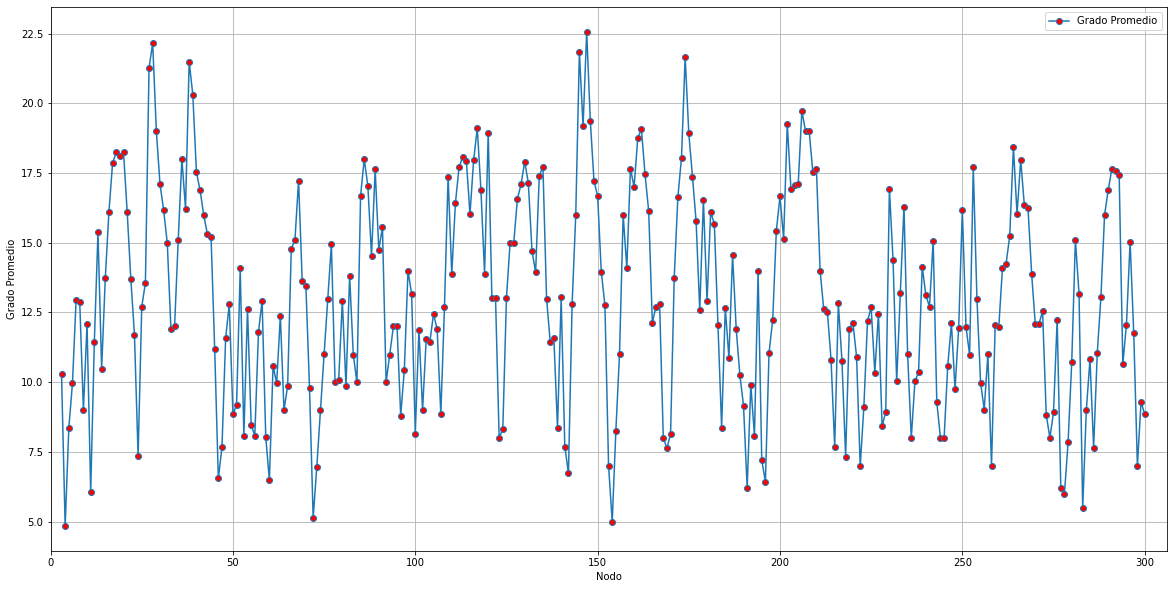

In [75]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
grados_promedio = []

for nodo in nodos:
    grados_nodo = [red.degree(nodo) for red in redes]  # Obtener los grados del nodo en cada red
    grado_promedio = np.mean(grados_nodo)
    grados_promedio.append(grado_promedio)

# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]

plt.figure(figsize=(20, 10))
plt.ylabel('Grado Promedio')
plt.xlabel('Nodo')
plt.xlim(-0, 306)
plt.plot(nodos_reetiquetados, grados_promedio, '-o', mfc="r", label="Grado Promedio")
plt.legend()
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Centralidad de Grado Promedio 75 redes R={D}A.png", dpi=200)
plt.show()

In [19]:
# Crear archivo .dat con los datos de la gráfica
data = np.column_stack((nodos_reetiquetados,  grados_promedio))
np.savetxt("datos_degree_centrality.dat", data, header="Nodo\tCentralidad de Cercanía Promedio", delimiter="\t", comments="")


# Crear archivo .txt con los datos de la gráfica
data_txt = np.column_stack((nodos_reetiquetados,  grados_promedio))
np.savetxt("datos_degree_centrality.txt", data_txt, fmt="%d %.6f", header="Nodo Centralidad_Cercanía_Promedio", delimiter="\t")

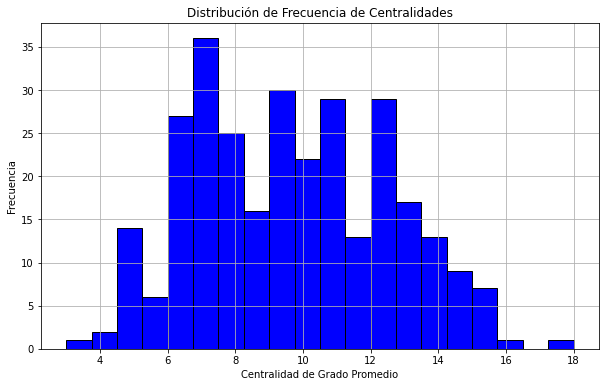

In [20]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(grados_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Grado Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidades')
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Distribucion de Grado Promedio 75 redes R={D}A.png", dpi=200)
plt.show()


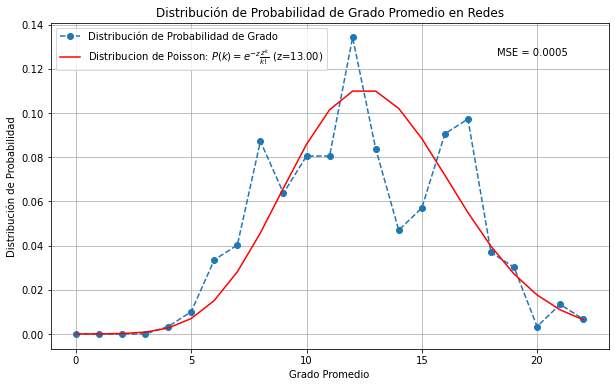

In [76]:
plt.figure(figsize=(10, 6))

# Calcular la distribución de probabilidad de grado
nodos_totales = len(nodos)
max_grado = int(max(grados_promedio))
distribucion_probabilidad = np.zeros(max_grado + 1)

for grado in grados_promedio:
    distribucion_probabilidad[int(grado)] += 1
    
distribucion_probabilidad /= nodos_totales

# Graficar la distribución de probabilidad de grado
plt.plot(range(len(distribucion_probabilidad)), distribucion_probabilidad, 'o--', label='Distribución de Probabilidad de Grado')

# Ajuste con la Topología de Poisson
z = np.mean(grados_promedio)
poisson_vals = [poisson.pmf(k, z) for k in range(len(distribucion_probabilidad))]
plt.plot(range(len(distribucion_probabilidad)), poisson_vals, 'r', label=f'Distribucion de Poisson: $P(k) = e^{{-z}} \\frac{{z^k}}{{k!}}$ (z={z:.2f})')

# Calcular el Error Cuadrático Medio (MSE) entre la distribución observada y la de Poisson ajustada
mse = np.mean((distribucion_probabilidad - poisson_vals)**2)
plt.text(0.8, 0.9, f'MSE = {mse:.4f}', transform=plt.gca().transAxes)

plt.xlabel('Grado Promedio')
plt.ylabel('Distribución de Probabilidad')
plt.title('Distribución de Probabilidad de Grado Promedio en Redes')
plt.legend()
plt.grid(True)

if save_graph.lower() == 'y':
    plt.savefig(f'Distribucion de Probabilidad de Grado Promedio 75 redes R={D}A.png', dpi=200)
plt.show()


In [22]:
#esta funcion hace un ranking de las 20 mayores centralidades y toma en cuanta los 3 pimeros atomos de la proteina
def top(centrality):  # top 20
    top = list(reversed(sorted((rank, node) for node, rank in centrality.items())))[:20]
    nodos_ranking = [node + 3 for rank, node in top]  # Aumentar en 3 unidades los números de los nodos en el ranking
    return nodos_ranking

In [23]:
#Calcula las 20 mayores centralidades de grado promedio de las redes
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
grados_promedio = []

for nodo in nodos:
    centralidades_nodo = [nx.degree_centrality(red)[nodo] for red in redes]  # Obtener las centralidades de grado del nodo en cada red
    grado_promedio = np.mean(centralidades_nodo)
    grados_promedio.append(grado_promedio)

# Crear un diccionario de nodos y sus grados promedio
diccionario_grados = {nodo: grado for nodo, grado in zip(nodos, grados_promedio)}

# Obtener los 20 nodos con mayor centralidad de grado
nodos_top_20 = top(diccionario_grados)[:20]

print("Top 20 nodos de mayor centralidad de grado:")
for nodo in nodos_top_20:
    print(nodo)




Top 20 nodos de mayor centralidad de grado:
28
27
20
160
173
19
18
176
115
29
162
120
38
17
39
117
175
146
291
163


In [24]:
# Crear un diccionario de nodos y sus grados promedio
diccionario_grados = {nodo: grado for nodo, grado in zip(nodos, grados_promedio)}

# Obtener los 20 nodos con mayor centralidad de grado
nodos_top_20 = top(diccionario_grados)[:20]
    
# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Grado Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_grados[nodo-3]}")    


Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Grado Promedio
28		0.0606060606060606
27		0.053602693602693596
20		0.05239057239057239
160		0.052076318742985406
173		0.0516273849607183
19		0.05144781144781145
18		0.05077441077441078
176		0.050505050505050504
115		0.050505050505050504
29		0.0504601571268238
162		0.05032547699214366
120		0.05023569023569024
38		0.05023569023569024
17		0.04983164983164983
39		0.049607182940516276
117		0.049068462401795736
175		0.04875420875420875
146		0.04799102132435466
291		0.04794612794612795
163		0.04718294051627385


# El programa calcula y muestra el grado de cercania de cada nodo en las redes, representado en un gráfico de líneas.

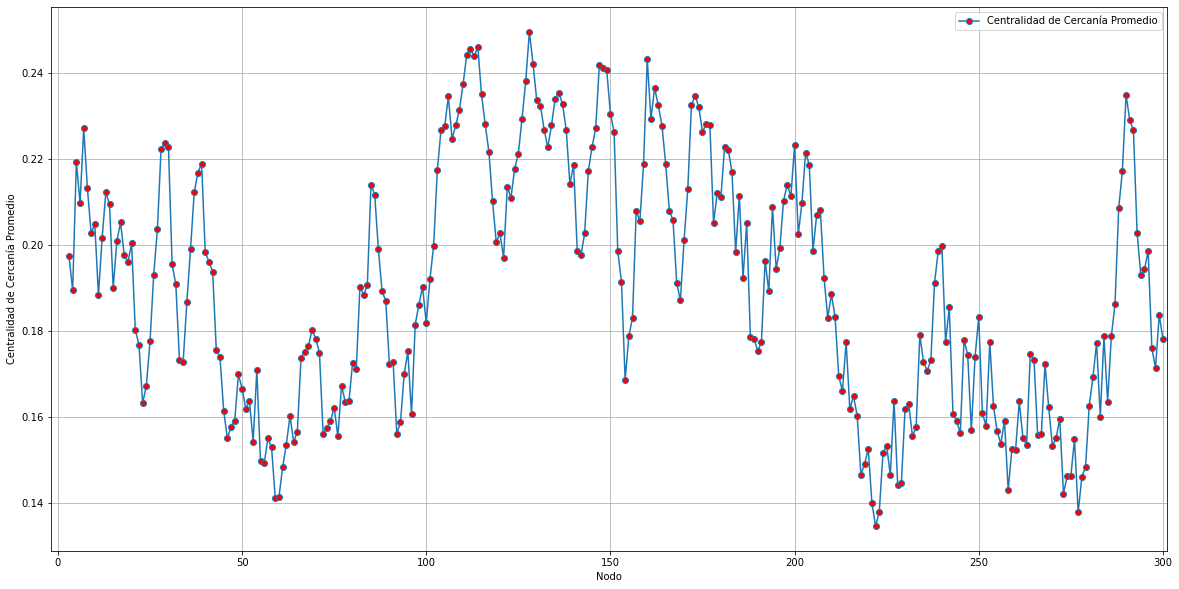

In [25]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
centralidades_promedio = []

for nodo in nodos:
    centralidades_nodo = [nx.closeness_centrality(red)[nodo] for red in redes]  # Obtener las centralidades de cercanía del nodo en cada red
    centralidad_promedio = np.mean(centralidades_nodo)
    centralidades_promedio.append(centralidad_promedio)
    
# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]    

plt.figure(figsize=(20, 10))
plt.ylabel('Centralidad de Cercanía Promedio')
plt.xlabel('Nodo')
plt.xlim(-2, 301)
plt.plot(nodos_reetiquetados, centralidades_promedio, '-o', mfc="r", label="Centralidad de Cercanía Promedio")
plt.legend()
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Centralidad de Cercanía Promedio 75 redes R={D}A.png", dpi=200)
plt.show()

In [45]:
# Crear archivo .dat con los datos de la gráfica
data = np.column_stack((nodos_reetiquetados, centralidades_promedio))
np.savetxt("datos_closeness_centrality.dat", data, header="Nodo\tCentralidad de Cercanía Promedio", delimiter="\t", comments="")


# Crear archivo .txt con los datos de la gráfica
data_txt = np.column_stack((nodos_reetiquetados, centralidades_promedio))
np.savetxt("datos_closeness_centrality.txt", data_txt, fmt="%d %.6f", header="Nodo Centralidad_Cercanía_Promedio", delimiter="\t")

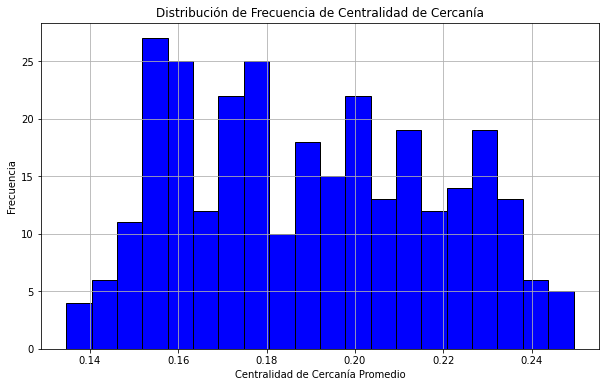

In [46]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(centralidades_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Cercanía Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidad de Cercanía')
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Distribucion de Centralidad de Cercanía Promedio 75 redes R={D}A.png", dpi=200)
plt.show()


In [47]:
# Crear un diccionario de nodos y sus centralidades promedio
diccionario_centralidades = {nodo: centralidad for nodo, centralidad in zip(nodos, centralidades_promedio)}

# Obtener los 20 nodos con mayor centralidad de cercanía
nodos_top_20 = top(diccionario_centralidades)[:20]

# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Cercanía Promedio Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_centralidades[nodo-3]}") 


Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Cercanía Promedio Promedio
128		0.24947317596342145
114		0.24599020722329848
112		0.24553748029325698
111		0.2441997449586465
113		0.24381815148847225
160		0.24312329453802467
129		0.24202122779969776
147		0.2418634188278421
148		0.24116051332988225
149		0.24056945711860056
127		0.23802487393335034
110		0.23735430227289156
162		0.23644460319875468
136		0.23535924277971124
115		0.23495740565185572
290		0.2348426247287827
173		0.23467706587683457
106		0.23447256103336636
135		0.23396436699341047
130		0.2335674624991626


# El programa calcula y muestra la centralidad de intermediacion de cada nodo en las redes, representado en un gráfico de líneas.

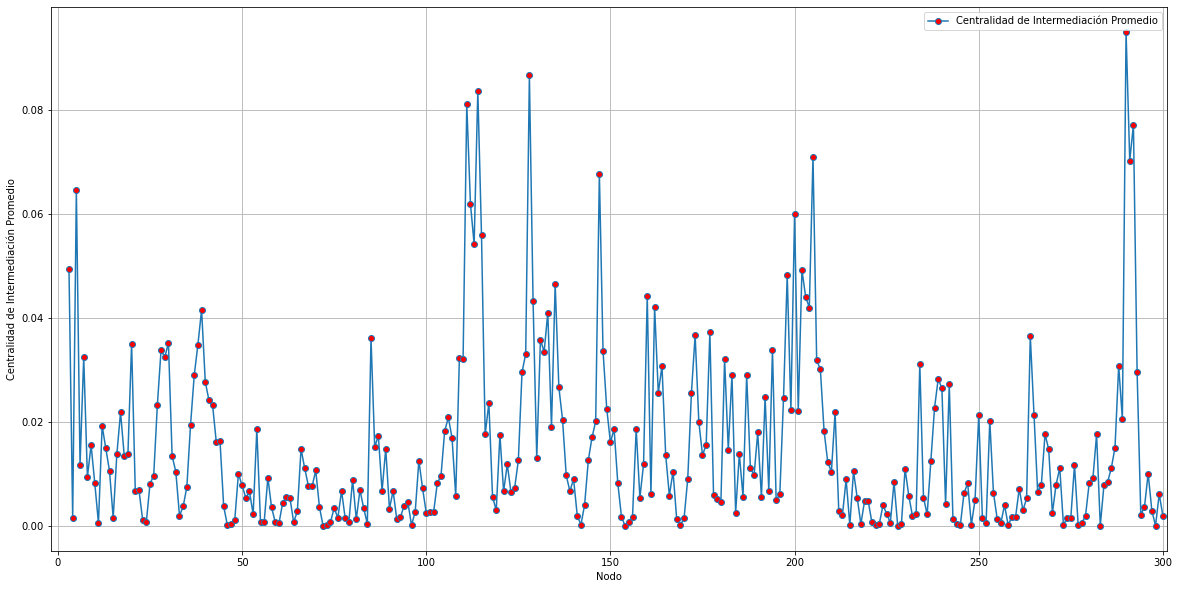

In [48]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
centralidades_promedio = []

for nodo in nodos:
    centralidades_nodo = [nx.betweenness_centrality(red)[nodo] for red in redes]  # Obtener las centralidades de intermediación del nodo en cada red
    centralidad_promedio = np.mean(centralidades_nodo)
    centralidades_promedio.append(centralidad_promedio)
# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]
plt.figure(figsize=(20, 10))
plt.ylabel('Centralidad de Intermediación Promedio')
plt.xlabel('Nodo')
plt.xlim(-2, 301)
plt.plot(nodos_reetiquetados, centralidades_promedio, '-o', mfc="r", label="Centralidad de Intermediación Promedio")
plt.legend()
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Centralidad de Intermediación Promedio 75 redes R={D}A.png", dpi=200)
plt.show()


In [49]:
# Crear archivo .dat con los datos de la gráfica
data = np.column_stack((nodos_reetiquetados, centralidades_promedio))
np.savetxt("datos_betweenness_centrality.dat", data, header="Nodo\tCentralidad de Cercanía Promedio", delimiter="\t", comments="")


# Crear archivo .txt con los datos de la gráfica
data_txt = np.column_stack((nodos_reetiquetados, centralidades_promedio))
np.savetxt("datos_betweenness_centrality.txt", data_txt, fmt="%d %.6f", header="Nodo Centralidad_Cercanía_Promedio", delimiter="\t")

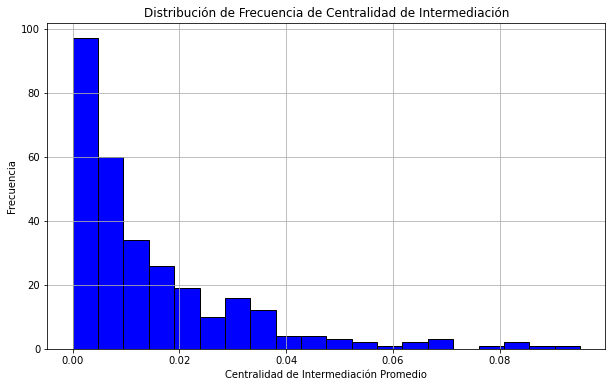

In [50]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(centralidades_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Intermediación Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidad de Intermediación')
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Distribucion de Centralidad de Intermediación Promedio 75 redes R={D}A.png", dpi=200)
plt.show()

In [51]:
# Crear un diccionario de nodos y sus centralidades promedio
diccionario_centralidades = {nodo: centralidad for nodo, centralidad in zip(nodos, centralidades_promedio)}

# Obtener los 20 nodos con mayor grado de intermediación
nodos_top_20 = top(diccionario_centralidades)[:20]
    
# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Intermediación Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_centralidades[nodo-3]}") 


Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Intermediación Promedio
290		0.09501247141121329
128		0.08664142337642083
114		0.08370024903308851
111		0.0810599114031759
292		0.0771491974130629
205		0.07103607243739773
291		0.07025985551131628
147		0.06769551819120614
5		0.0645779192904003
112		0.06194565309460315
200		0.05992449766430795
115		0.05594300333405693
113		0.05419935751711036
3		0.04942970019008286
202		0.04923978825555998
198		0.04827050467316917
135		0.046552570616157495
160		0.044303015181003096
203		0.04412003021805036
129		0.04328093095062641


# El programa calcula y muestra la centralidad de eigenvector de cada nodo en las redes, representado en un gráfico de líneas.


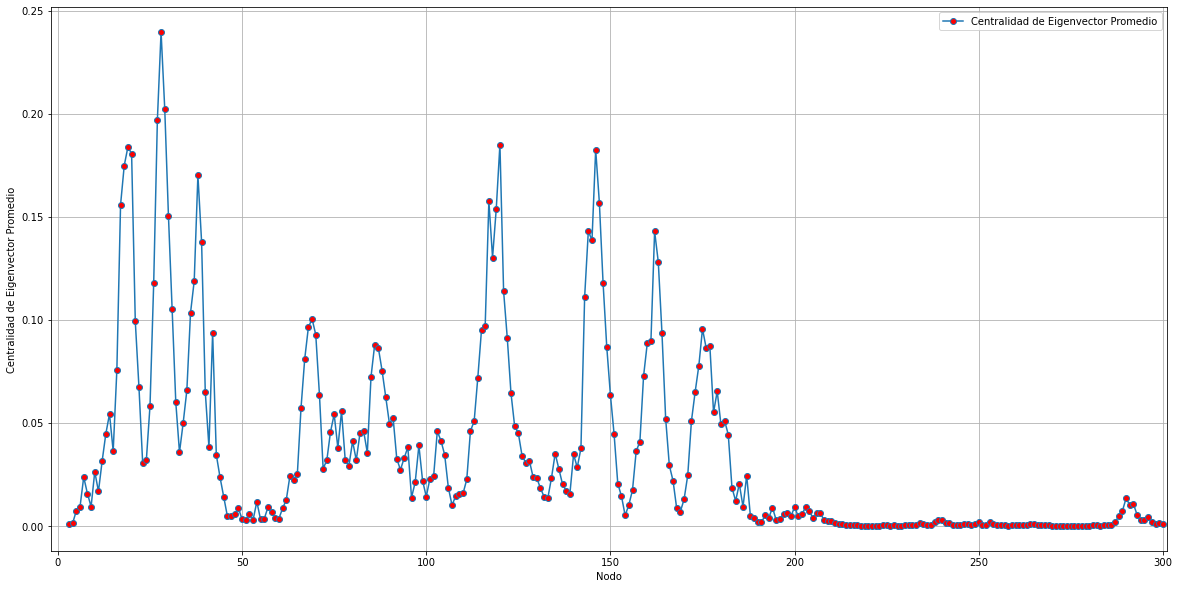

In [52]:
nodos = redes[0].nodes()  # Obtener la lista de nodos de una de las redes
centralidades_promedio = []

for nodo in nodos:
    centralidades_nodo = []
    for red in redes:
        try:
            centralidad = nx.eigenvector_centrality(red, max_iter=1500)[nodo]  # Obtener la centralidad de eigenvector del nodo en cada red
            centralidades_nodo.append(centralidad)
        except nx.PowerIterationFailedConvergence:
            print(f"Convergencia fallida para el nodo {nodo} en una de las redes")
            continue
    
    if centralidades_nodo:
        centralidad_promedio = np.mean(centralidades_nodo)
        centralidades_promedio.append(centralidad_promedio)
# Reetiquetar los números de nodo sumando 3 unidades
nodos_reetiquetados = [nodo + 3 for nodo in nodos]
plt.figure(figsize=(20, 10))
plt.ylabel('Centralidad de Eigenvector Promedio')
plt.xlabel('Nodo')
plt.xlim(-2, 301)
plt.plot(nodos_reetiquetados, centralidades_promedio, '-o', mfc="r", label="Centralidad de Eigenvector Promedio")
plt.legend()
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Centralidad de Eigenvector Promedio 75 redes R={D}A.png", dpi=200)
plt.show()

# Crear archivo .dat con los datos de la gráfica
data = np.column_stack((nodos_reetiquetados, centralidades_promedio))
np.savetxt("datos_eigenvector_centrality_centrality.dat", data, header="Nodo\tCentralidad de Cercanía Promedio", delimiter="\t", comments="")

In [53]:
# Crear archivo .dat con los datos de la gráfica
data = np.column_stack((nodos_reetiquetados, centralidades_promedio))
np.savetxt("datos_eigenvector_centrality.dat", data, header="Nodo\tCentralidad de Cercanía Promedio", delimiter="\t", comments="")


# Crear archivo .txt con los datos de la gráfica
data_txt = np.column_stack((nodos_reetiquetados, centralidades_promedio))
np.savetxt("datos_eigenvector_centrality.txt", data_txt, fmt="%d %.6f", header="Nodo Centralidad_Cercanía_Promedio", delimiter="\t")

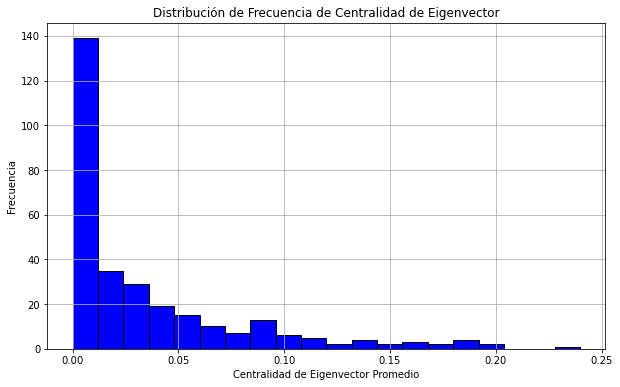

In [54]:
# Crear un histograma de la distribución de frecuencia de las centralidades
plt.figure(figsize=(10, 6))
plt.hist(centralidades_promedio, bins=20, color='blue', edgecolor='black')
plt.xlabel('Centralidad de Eigenvector Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia de Centralidad de Eigenvector')
plt.grid(True)
if save_graph.lower() == 'y':
    plt.savefig(f"Distribucion de Centralidad de Eigenvector Promedio 75 redes R={D}A.png", dpi=200)
plt.show()

In [55]:
# Crear un diccionario de nodos y sus centralidades promedio
diccionario_centralidades = {nodo: centralidad for nodo, centralidad in zip(nodos, centralidades_promedio)}

# Obtener los 20 nodos con mayor centralidad de eigenvector
nodos_top_20 = top(diccionario_centralidades)[:20]
    
# Mostrar la tabla de centralidades de grado para los nodos top 20
print("\nTabla de Centralidades de Grado para los Top 20 Nodos:")
print("Nodo\t\tCentralidad de Eigenvector Promedio")
for nodo in nodos_top_20:
    print(f"{nodo}\t\t{diccionario_centralidades[nodo-3]}")     



Tabla de Centralidades de Grado para los Top 20 Nodos:
Nodo		Centralidad de Eigenvector Promedio
28		0.2397653393467664
29		0.20235687283015463
27		0.19715856975826493
120		0.18513567144202772
19		0.18398246111347563
146		0.18266743895673976
20		0.18066865722656422
18		0.17494542635428573
38		0.1702013403241948
117		0.15766652365490033
147		0.15691350998501274
17		0.15587146937463356
119		0.15381872942214414
30		0.15067670603592828
162		0.14307175386343624
144		0.14302521298056403
145		0.1387532456280773
39		0.13804777899085652
118		0.13029094056692309
163		0.1280885522169305
